<a href="https://colab.research.google.com/github/polortiz4/Smart-Cameras/blob/master/Smart_Cameras_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW1 
Pablo Ortiz
01/28/19



In [15]:
#Download
!wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
  
#Extract  
import tarfile
tf = tarfile.open("INRIAPerson.tar")
tf.extractall()

--2019-01-28 23:02:25--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
           => ‘INRIAPerson.tar’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE INRIAPerson.tar ... 1016094720
==> PASV ... done.    ==> RETR INRIAPerson.tar ... done.
Length: 1016094720 (969M) (unauthoritative)

INRIAPerson.tar     100%[===================>] 969.02M  29.9MB/s    in 34s     

2019-01-28 23:03:00 (28.5 MB/s) - ‘INRIAPerson.tar’ saved [1016094720]



In [0]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

In [0]:
num_classes = 2
batch_size = 32
epochs = 10
class_names = ['Person', 'No Person']
im_size1, im_size2 = 256, 256

In [0]:
# preprocess the data
def preprocess(im):
  im1 = cv2.resize(im, (im_size1, im_size2)) 
  im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
  im1 = im1 / np.amax(im1)
  im1 = im1 * 1.0
  return im1

In [0]:
# Collect the test image filenames from the INRIAPerson folder

def collect_filenames(image_type):
  file_names = []
  label = []
  for dirpath, dirnames, filenames in os.walk(os.path.join("INRIAPerson/", image_type)):
    for filename in [f for f in filenames if f.endswith(".png") | f.endswith(".jpg")]:
      if dirpath.endswith("/pos"):
        label = np.append(label, 0)
      elif dirpath.endswith("/neg"):
        label = np.append(label, 1)
      file_names = np.append(file_names, os.path.join(dirpath, filename))
  Test_num_of_data = len(file_names)
  #Test_DATA = np.zeros([Test_num_of_data, im_size2, im_size1, 3])
  
  return label, file_names, Test_num_of_data

In [0]:
def DATA_matrix(Num_of_data, File_names):
  DATA = np.zeros([Num_of_data, im_size2, im_size1, 3])
  for i in range(Num_of_data):
    ## load one image
    img = cv2.imread(File_names[i])
    ## preprocess it
    DATA[i,:,:,:] = preprocess(img)
    
  return DATA

In [0]:
import os
import numpy as np
test_label, test_file_names, Test_num_of_data = collect_filenames('Test')
train_label, train_file_names, Num_of_data = collect_filenames('Train')

In [0]:
import cv2
train_data = DATA_matrix(Num_of_data, train_file_names)
test_data = DATA_matrix(Test_num_of_data, test_file_names)

np.save('train_data', train_data)
np.save('train_label', train_label)
np.save('test_label', test_label)
np.save('test_data', test_data)

In [0]:
## When you need to load it
x_train = np.load('train_data.npy')
y_train = np.load('train_label.npy')
x_test = np.load('test_data.npy')
y_test = np.load('test_label.npy')

In [0]:
# Convert and pre-processing

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


In [25]:
# define the neural network model

def base_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], data_format = 'channels_last'))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))


# Train model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_n = base_model()
cnn_n.summary()

# Fit model

cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 254, 30)       73760     
_________________________________________________________________
activation_8 (Activation)    (None, 32, 254, 30)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 127, 15)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 127, 15)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 127, 15)       18496     
__________

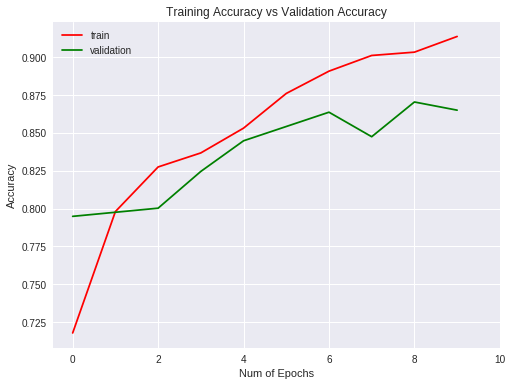

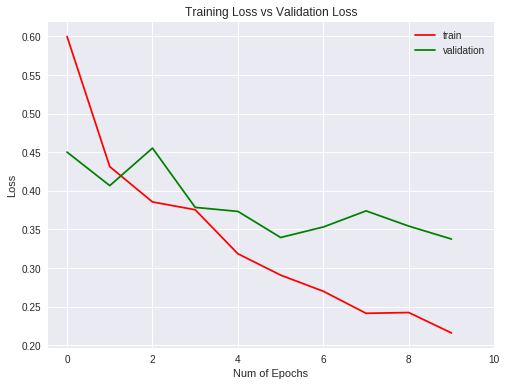

In [26]:
# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()